In [1]:
"""
description DJIA 30股票时间序列
author lj.michale
date 2022-06-1
"""

'\ndescription DJIA 30股票时间序列\nauthor lj.michale\ndate 2022-06-1\n'

In [2]:
# !pip install chart-studio

In [3]:
# 导入必要的包
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from plotly import tools
# import plotly.plotly as py
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

In [4]:
plt.style.use('fivethirtyeight') 

In [5]:
"""
导入时间序列数据
使用的数据
Google Stocks Data
Humidity in different world cities
Microsoft Stocks Data
Pressure in different world cities
这里使用parse_dates参数将所需的时间序列列导入为datetime列，并使用index_col参数将其选择为数据框的索引。
"""
google = pd.read_csv('E:\\company\\tmp\\Stock-Time-Series-Analysis\\data\\GOOGL_2006-01-01_to_2018-01-01.csv', 
index_col='Date', parse_dates=['Date'])

google.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [6]:
"""
1.2 清洗以及准备时间序列数据
如何准备数据？
Google 数据没有缺失值，所以我们这里不用处理缺失值。如果有缺失值的话，我们可以使用 fillna() 方法并设置参数 ffill 来填充缺失值。

该参数 ffill 意味着用空白处前面的的最后一个的有效观察值来填补缺失值。
"""
google.isnull().any()

Open      False
High      False
Low       False
Close     False
Volume    False
Name      False
dtype: bool

In [7]:
"""
可视化数据集
"""

'\n可视化数据集\n'

<Figure size 432x288 with 0 Axes>

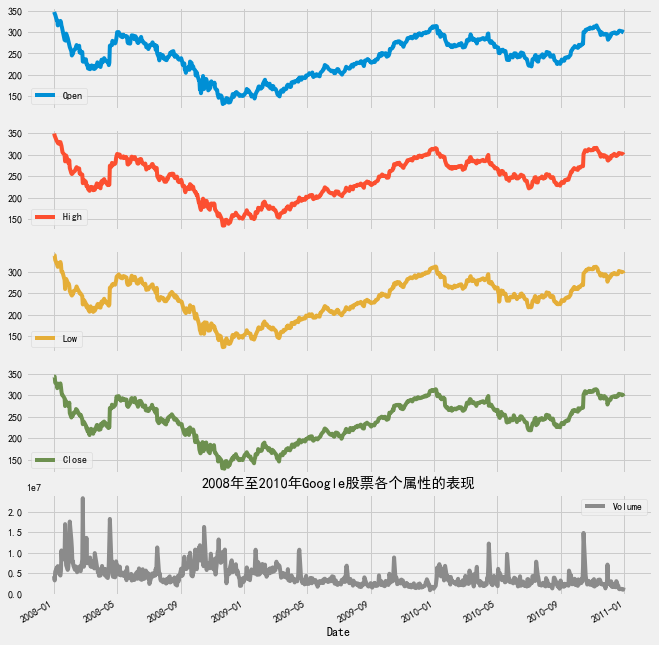

In [8]:
plt.figure()
plt.rc('font',family='SimHei',size=10) # 解决画图过程中的中文乱码问题
google['2008':'2010'].plot(subplots=True, figsize=(10,12))
plt.title('2008年至2010年Google股票各个属性的表现')
plt.show()

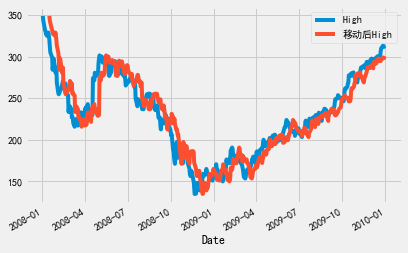

In [9]:
"""
移动（Shift）和滞后（Lags）
我们可以使用可选的时间频率将索引按所需的周期数移动。
可让我们将时间序列与其自身的过去进行比较时，这很有用
"""
google.loc['2008':'2009'].High.plot(legend=True)
google.loc['2008':'2009'].High.shift(10).plot(legend=True,label='移动后High')
plt.show()

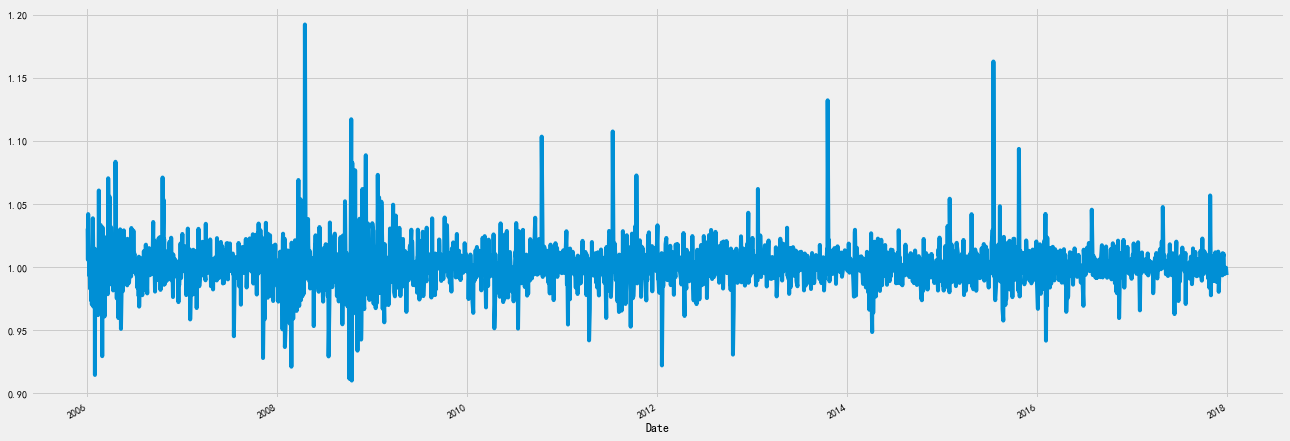

In [10]:
"""
金融与统计
"""
# 百分比变化量
# div为除法，shift()表示向后移动一期，这里是一天，因为是日数据
google['Change'] = google.High.div(google.High.shift())
google['Change'].plot(figsize=(20,8))

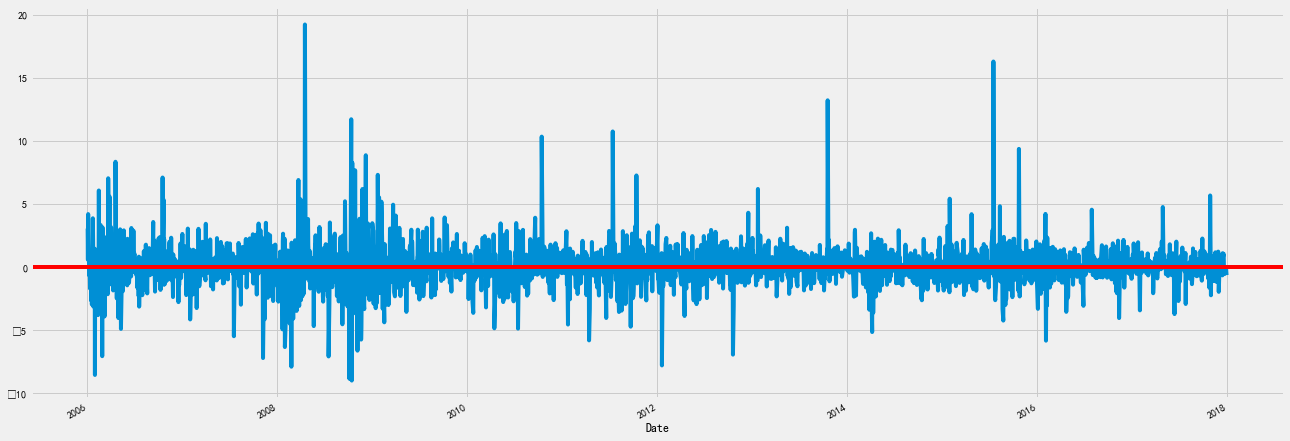

In [11]:
# 股票收益
plt.figure()
google['Return'] = google.Change.sub(1).mul(100)
google['Return'].plot(figsize=(20,8))
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

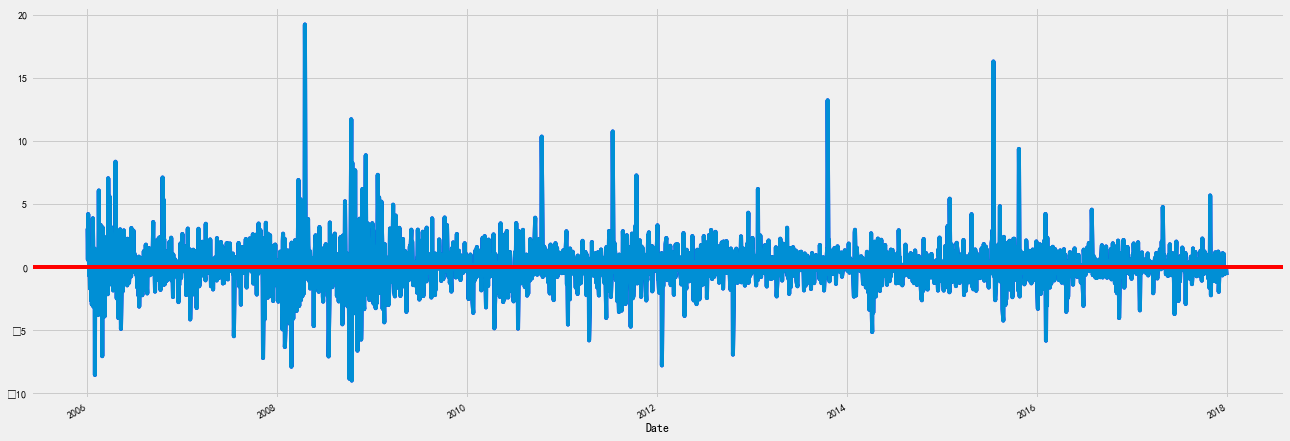

In [12]:
# 另一个计算收益的方法
plt.figure()
google.High.pct_change().mul(100).plot(figsize=(20,6),color='b') 
google['Return'].plot(figsize=(20,8))
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

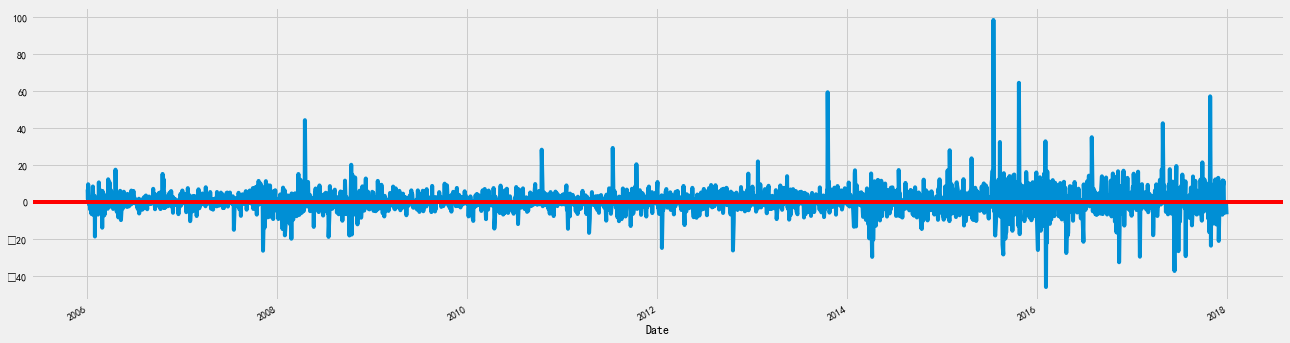

In [13]:
# 连续的行中的绝对数值变化
# 用差分
google.High.diff().plot(figsize=(20,6))
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [14]:
"""
比较两个或多个时间序列
我们将通过归一化两个时间序列再进行比较。
这是通过将所有时间序列的每个时间序列元素除以第一个元素来实现的。
这样，两个系列都从同一点开始，可以轻松进行比较。
"""
# 我们将比较微软和Google的股价
microsoft = pd.read_csv('E:\\company\\tmp\\Stock-Time-Series-Analysis\\data\\MSFT_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])

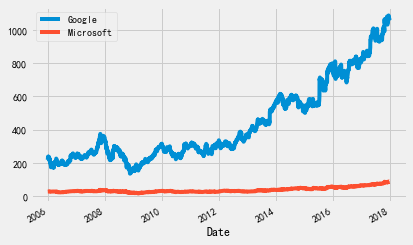

In [15]:
# 可视化
plt.figure()
plt.rc('font',family='SimHei',size=10) # 解决画图过程中的中文乱码问题
google.High.plot()
microsoft.High.plot()
plt.legend(['Google','Microsoft'])
plt.show()

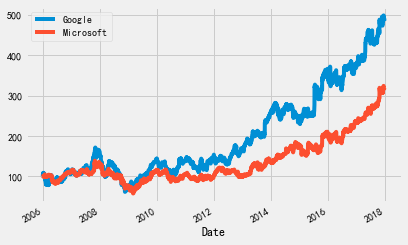

In [16]:
# 标准化并进行比较
# 全部都除以第一行的数据
# 两支股票都从100开始
normalized_google = google.High.div(google.High.iloc[0]).mul(100)
normalized_microsoft = microsoft.High.div(microsoft.High.iloc[0]).mul(100)

# 可视化
plt.figure()
normalized_google.plot()
normalized_microsoft.plot()
plt.legend(['Google','Microsoft'])
plt.show()

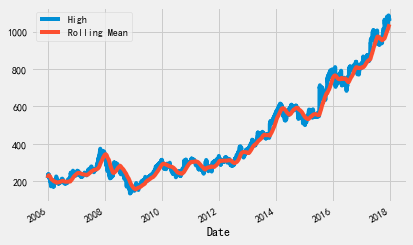

In [17]:
"""
Window函数
Window 函数用于标识子periods，计算子periods的子度量metrics。
Rolling - 大小相同，且滑动步数相同
Expanding - 包含所有先前值
"""
# Rolling window 函数
# Rolling 90天
rolling_google = google.High.rolling('90D').mean()

# 与Rolling前数据进行比较
google.High.plot()
rolling_google.plot()
plt.legend(['High','Rolling Mean'])
plt.show()

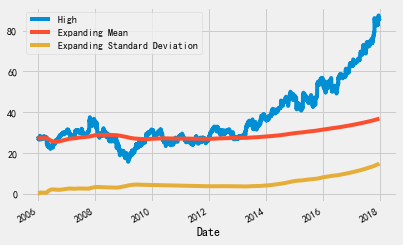

In [18]:
# 可看出，Rolling均值图是原始图的平滑版本。
# Expanding window 函数
microsoft_mean = microsoft.High.expanding().mean()
microsoft_std = microsoft.High.expanding().std()
microsoft.High.plot()
microsoft_mean.plot()
microsoft_std.plot()
plt.legend(['High','Expanding Mean','Expanding Standard Deviation'])
plt.show()

In [19]:
"""
OHLC图
O:代表开盘价
Open H:代表最高价
High L: 代表最低价
Low C: 代表收盘价
"""
# 2008六月的OHLC图
trace = go.Ohlc(x=google['06-2008'].index,
                open=google['06-2008'].Open,
                high=google['06-2008'].High,
                low=google['06-2008'].Low,
                close=google['06-2008'].Close)
data = [trace]
iplot(data, filename='simple_ohlc')

In [20]:
# 2008年OHLC图
trace = go.Ohlc(x=google['2008'].index,
                open=google['2008'].Open,
                high=google['2008'].High,
                low=google['2008'].Low,
                close=google['2008'].Close)
data = [trace]
iplot(data, filename='simple_ohlc')

In [21]:
# 2006-2018年OLHC图
trace = go.Ohlc(x=google.index,
                open=google.Open,
                high=google.High,
                low=google.Low,
                close=google.Close)
data = [trace]
iplot(data, filename='simple_ohlc')

In [22]:
"""
 蜡烛图
这种图表用作交易工具，以可视化和分析证券，衍生工具，货币，股票，债券，商品等随时间的价格变动。
尽管烛台图中使用的符号类似于箱形图，但它们的功能不同，不要彼此混淆。
蜡烛图通过使用类似烛台的符号来显示价格信息的多个维度，例如开盘价，收盘价，最高价和最低价。
每个符号代表单个时间段（分钟，小时，天，月等）的交易活动。每个烛台符号均沿时间轴绘制在x轴上，以显示一段时间内的交易活动。
蜡烛符号中的主要矩形称为real body，用于显示该时间段的开盘价和收盘价之间的范围。
从实体的底部和顶部延伸的线被称为上下阴影（或灯芯）。每个阴影代表所表示的时间段内交易的最高或最低价格。
当市场看涨（收盘价高于开盘价）时，机构的颜色通常为白色或绿色。但是，当市场看跌（收盘价低于开盘价）时，机构通常会被涂成黑色或红色。
"""
# 2008三月蜡烛图
trace = go.Candlestick(x=google['03-2008'].index,
                open=google['03-2008'].Open,
                high=google['03-2008'].High,
                low=google['03-2008'].Low,
                close=google['03-2008'].Close)
data = [trace]
iplot(data, filename='simple_candlestick')

In [23]:
# 2008蜡烛图
trace = go.Candlestick(x=google['2008'].index,
                open=google['2008'].Open,
                high=google['2008'].High,
                low=google['2008'].Low,
                close=google['2008'].Close)
data = [trace]
iplot(data, filename='simple_candlestick')

In [24]:
# 2006-2018蜡烛图
trace = go.Candlestick(x=google.index,
                open=google.Open,
                high=google.High,
                low=google.Low,
                close=google.Close)
data = [trace]
iplot(data, filename='simple_candlestick')

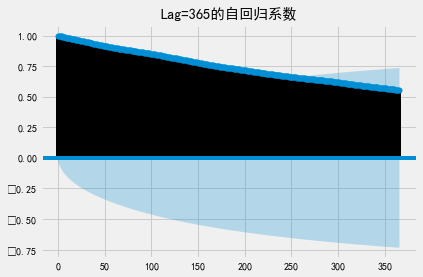

In [25]:
"""
自回归系数Autocorrelation与偏自回归系数Partial Autocorrelation
自回归系数Autocorrelation - 自相关函数（ACF）可测量序列在不同滞后情况下，与其自身的相关关系。
偏自回归系数Partial Autocorrelation - 偏自相关函数在另一角度上可以解释为该序列相对于其过去滞后值的做回归后的回归系数。
可以用与标准线性回归相同的方式解释这些术语，即：在使其他滞后（lags）保持不变的同时，特定滞后变化的贡献。
"""
# 自回归系数Autocorrelation
# Google股票自回归系数
plot_acf(google.High,lags=365,title="Lag=365的自回归系数")
plt.show()

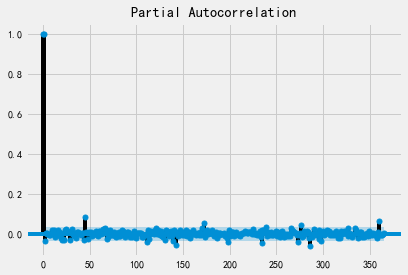

In [26]:
# 偏自回归系数Partial Autocorrelation
# google票价偏自回归系数
plot_pacf(google.High,lags=365)
plt.rc('font',family='SimHei',size=10)
plt.show()

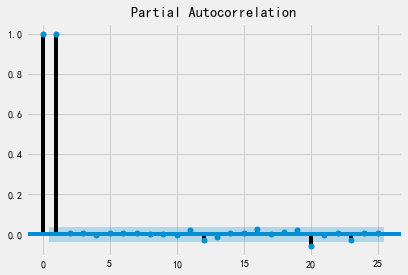

In [27]:
# 微软收盘价的PACF
plot_pacf(microsoft["Close"],lags=25)
plt.show()

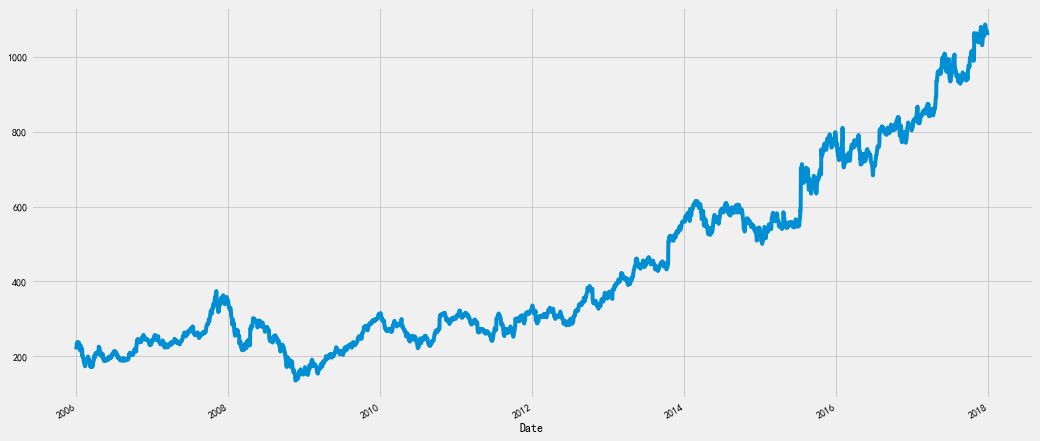

In [28]:
"""
时间序列分解与随机游走
1. 趋势、季节性与噪声
这些是时间序列的组成部分
趋势 - 时间序列的向上或向下一致的斜率
季节性 - 时间序列的清晰周期性模式（例如正弦函数）
噪声 - 离群值或缺失值
"""
google["High"].plot(figsize=(16,8))

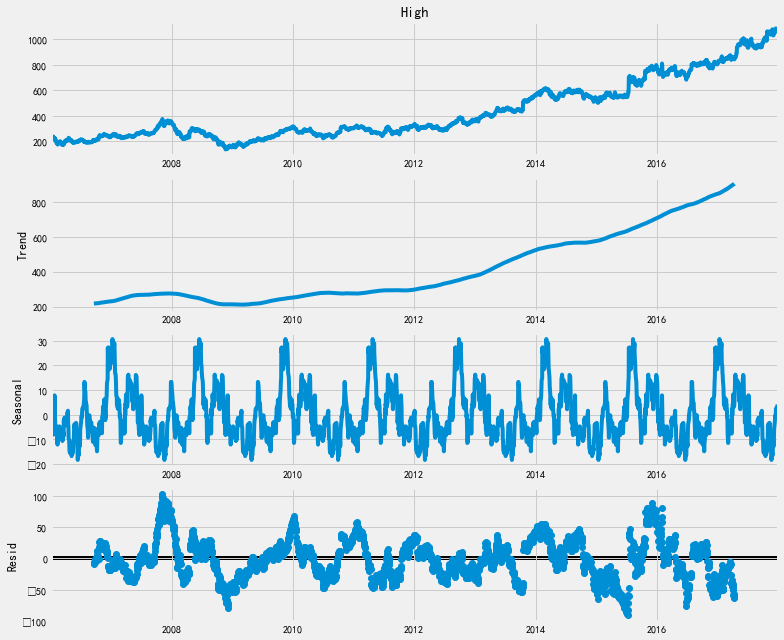

In [29]:
"""
从下的分解图我们可以看到：
上图中明显有上升趋势。
还可以看到统一的季节性变化。
代表异常值和缺失值的非均匀噪声
"""
# 现在我们分解它
rcParams['figure.figsize'] = 11, 9
decomposed_google_volume = sm.tsa.seasonal_decompose(google["High"],freq=360) 
figure = decomposed_google_volume.plot()
plt.show()

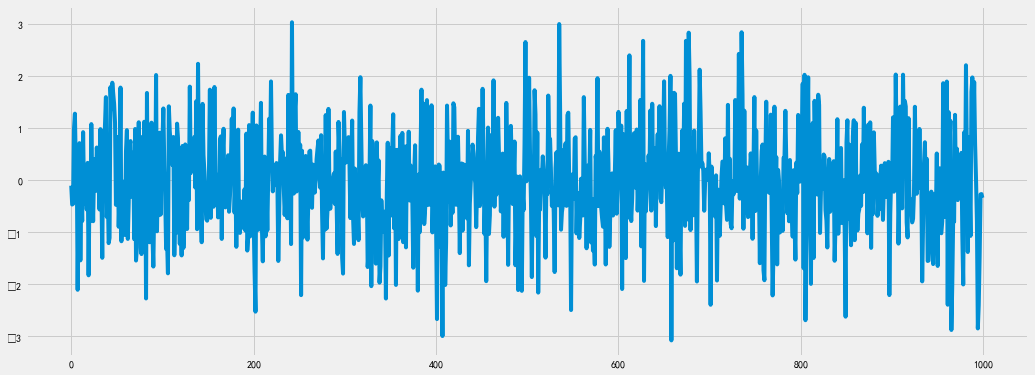

In [30]:
"""
白噪声
白噪声具有如下性质：
恒定均值
恒定方差
所有滞后之间的相关关系均为0
"""
# 画出白噪声
rcParams['figure.figsize'] = 16, 6
white_noise = np.random.normal(loc=0, scale=1, size=1000)
# 以上：loc表示期望，scale表示方差
plt.plot(white_noise)

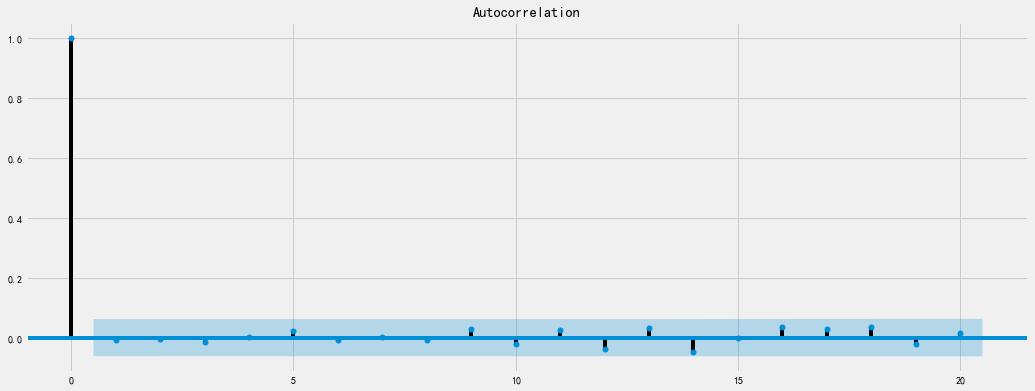

In [31]:
# 白噪声之间的自相关系数图
# 所有滞后在置信区间（阴影部分）内，在统计上不显著
plot_acf(white_noise,lags=20)
plt.show()

In [32]:
"""
随机游走
随机游走是一种数学对象，它描述由某些数学空间（例如整数）上的一系列随机步长构成的路径。
"""

'\n随机游走\n随机游走是一种数学对象，它描述由某些数学空间（例如整数）上的一系列随机步长构成的路径。\n'

In [33]:
"""
Augmented Dickey-Fuller test
Augmented Dickey-Fuller Test 是一种统计学的检测方法，用于检测一个有某种趋势的时间序列的平稳性。是一种重要的单根检测方法。
其初始假设null hypothesis是该序列不稳定(存在单位根)，检测可以有两种途径:
一是统计量小于特定拒绝域值；
二是p-value大于相应域值。如果是，则拒绝假设，认为序列是稳定的。
"""
# 对谷歌和微软股票交易量进行Augmented Dickey-Fuller检验
adf = adfuller(microsoft["Volume"])
print("p-value of microsoft: {}".format(float(adf[1])))
adf = adfuller(google["Volume"])
print("p-value of google: {}".format(float(adf[1])))

p-value of microsoft: 0.00032015252776519774
p-value of google: 6.510719605768313e-07


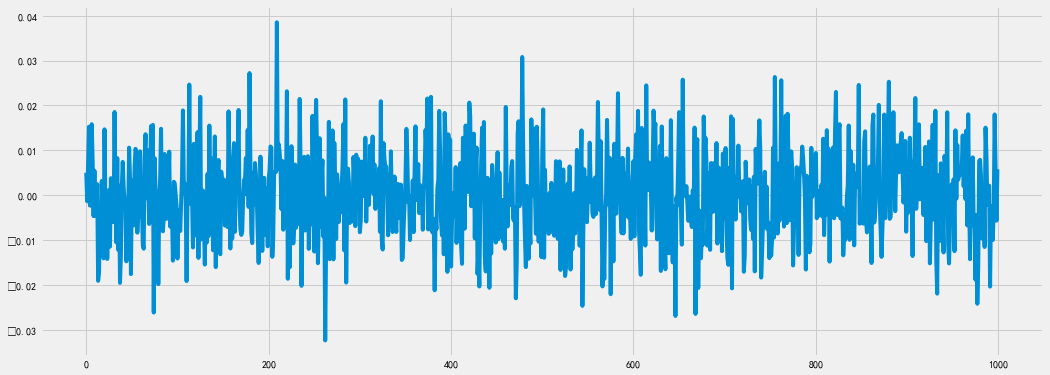

In [34]:
# 生成随机游走
seed(42)
rcParams['figure.figsize'] = 16, 6

# 从高斯分布生成随机数
random_walk = normal(loc=0, scale=0.01, size=1000)
plt.plot(random_walk)
plt.show()

In [35]:
fig = ff.create_distplot([random_walk],['Random Walk'],bin_size=0.001)
iplot(fig, filename='Basic Distplot')

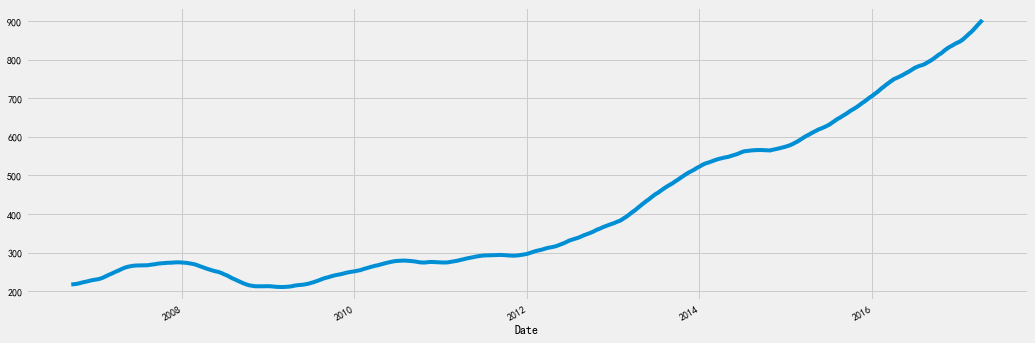

In [36]:
"""
平稳性
平稳时间序列是一种统计特性，例如均值，方差，自相关等不论时间怎么变化，他们都是恒定的。
强平稳性：是一个随着时间的推移，其无条件联合概率分布不会改变的随机过程。
因此，诸如均值和方差之类的参数也不会随时间变化而变化。其条件性非常强，一般很难满足。
弱平稳性：在整个过程中，均值，方差，自相关都是“恒定”的过程
平稳性很重要，因为依赖时间的非平稳序列具有太多的参数，无法在对时间序列建模时考虑到。
diff()（差分）方法可以轻松地将非平稳序列转换为平稳序列。
我们将尝试解析出上述分解后的时间序列中的季节成分。
"""
# 绘制原始的非平稳时间序列
decomposed_google_volume.trend.plot()

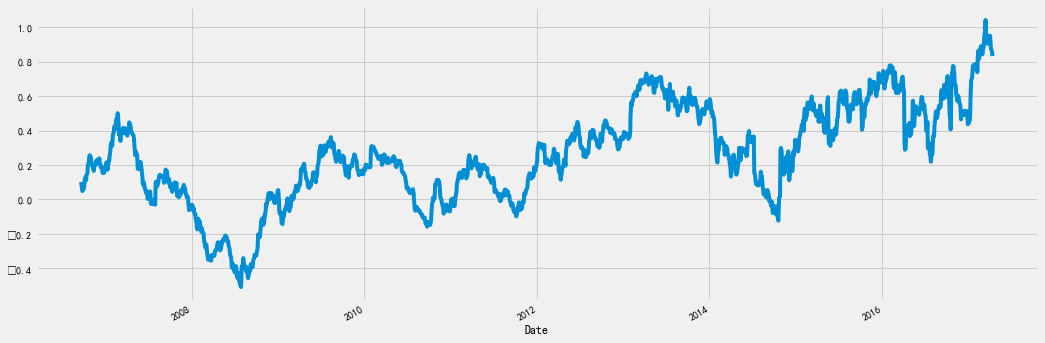

In [37]:
# 新的平稳的时间序列（使用diff()做了一阶差分）
decomposed_google_volume.trend.diff().plot()

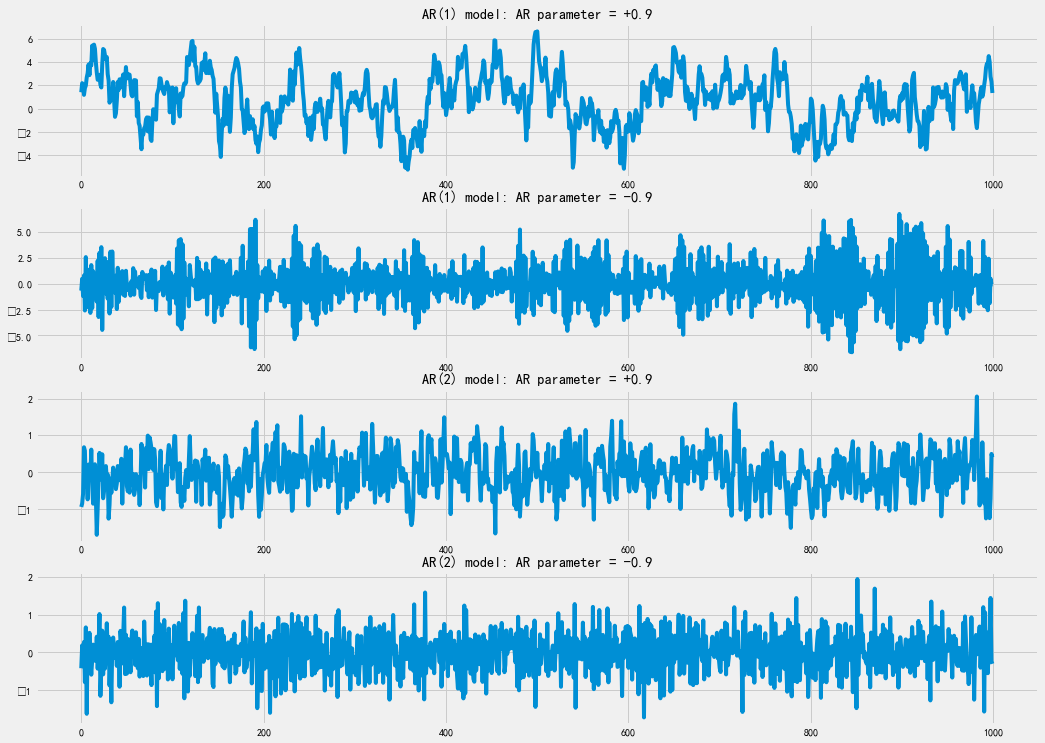

In [38]:
"""
AR 模型
自回归模型（AR）模型是一种随机过程的表示； 因此，自回归模型指定输出变量线性地依赖于其自身的先前值和随机项（一个不完全可预测的项）。
因此该模型采用随机差分方程的形式来表示。
"""
# 模拟 AR(1) 过程
# AR(1) model:AR parameter = +0.9
rcParams['figure.figsize'] = 16, 12
plt.rc('font',family='SimHei',size=10)
plt.subplot(4,1,1)
ar1 = np.array([1, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma1 = np.array([1])
AR1 = ArmaProcess(ar1, ma1)
sim1 = AR1.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = +0.9')
plt.plot(sim1)
# 后面会介绍MA(q)模型
# AR(1) MA(1) AR parameter = -0.9
plt.subplot(4,1,2)
ar2 = np.array([1, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma2 = np.array([1])
AR2 = ArmaProcess(ar2, ma2)
sim2 = AR2.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = -0.9')
plt.plot(sim2)
# AR(2) MA(1) AR parameter = 0.9
plt.subplot(4,1,3)
ar3 = np.array([2, -0.9]) # 我们选择 -0.9 作为 AR 参数： +0.9
ma3 = np.array([1])
AR3 = ArmaProcess(ar3, ma3)
sim3 = AR3.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = +0.9')
plt.plot(sim3)
# AR(2) MA(1) AR parameter = -0.9
plt.subplot(4,1,4)
ar4 = np.array([2, 0.9]) # 我们选择 +0.9 作为 AR 参数： -0.9
ma4 = np.array([1])
AR4 = ArmaProcess(ar4, ma4)
sim4 = AR4.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = -0.9')
plt.plot(sim4)
plt.show()

In [39]:
# 预测
model = ARMA(sim1, order=(1,0))
result = model.fit()
print(result.summary())
print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1415.701
Method:                       css-mle   S.D. of innovations              0.996
Date:                Wed, 01 Jun 2022   AIC                           2837.403
Time:                        12:00:04   BIC                           2852.126
Sample:                             0   HQIC                          2842.998
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7072      0.288      2.454      0.014       0.142       1.272
ar.L1.y        0.8916      0.014     62.742      0.000       0.864       0.919
                                    Roots           

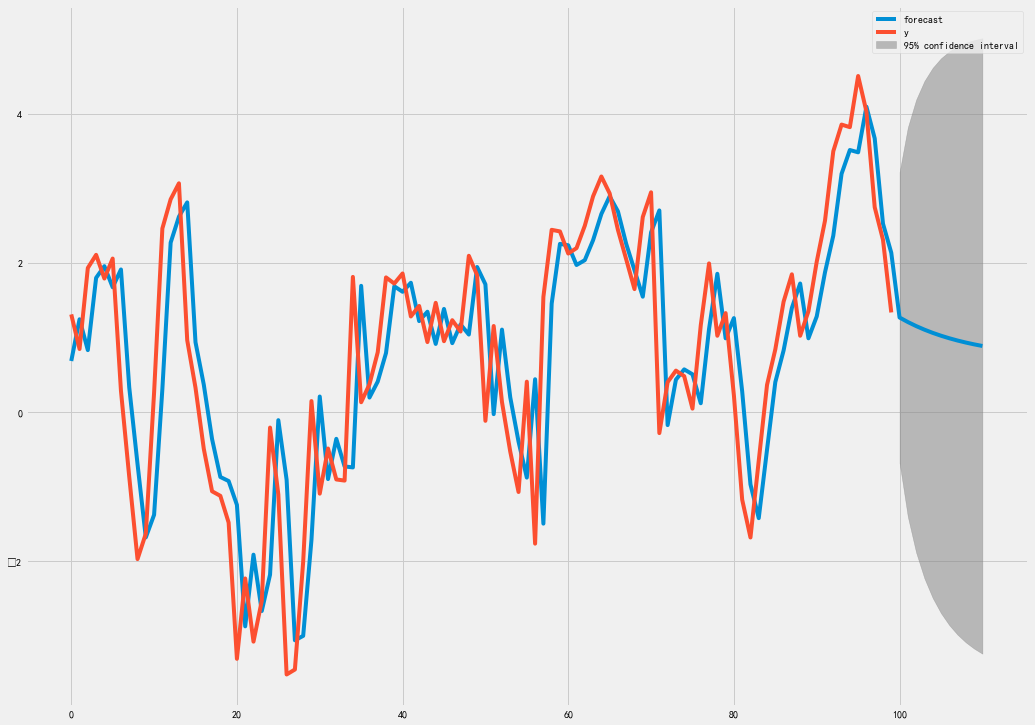

In [40]:
# ϕ 在 0.9 附近，我们可以选其作为我们AR模型的参数。
# 预测模型
# Predicting simulated AR(1) model 
result.plot_predict(start=900, end=1010)
plt.show()

In [41]:
rmse = math.sqrt(mean_squared_error(sim1[900:1011], result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 1.0408054536745255.


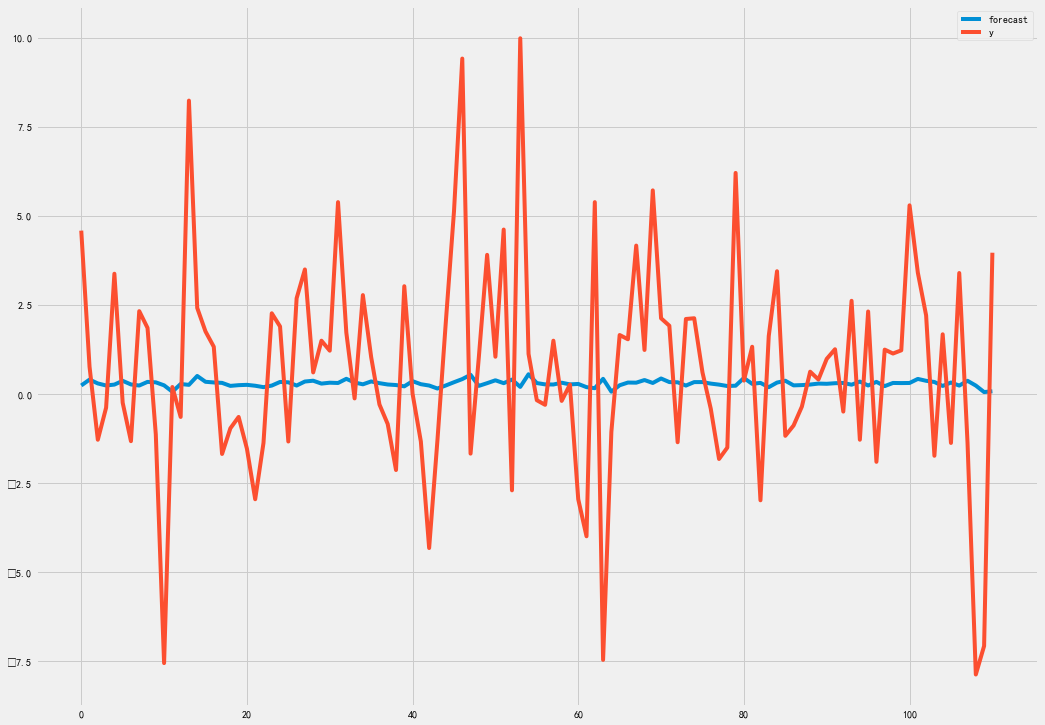

In [42]:
# y 是预测结果的可视化
# 预测谷歌股票
# Predicting closing prices of google
humid = ARMA(google["Close"].diff().iloc[1:].values, order=(1,0))
res = humid.fit()
res.plot_predict(start=900, end=1010)
plt.show()

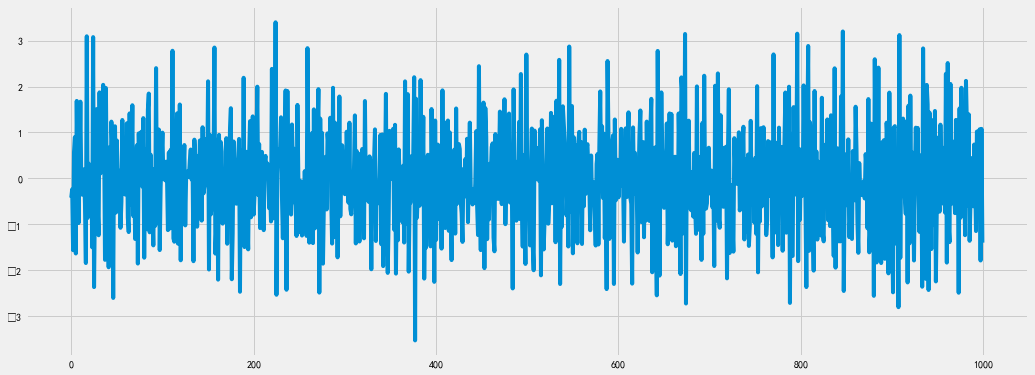

In [43]:
"""
MA 模型
即移动平均模型 (MA) model专门针对单变量时间序列建模。
移动平均模型指定输出变量线性地取决于随机（不完全可预测）项的当前值和各种过去值。
"""
# 模拟 MA(1)
rcParams['figure.figsize'] = 16, 6
ar1 = np.array([1])
ma1 = np.array([1, -0.5])
MA1 = ArmaProcess(ar1, ma1)
sim1 = MA1.generate_sample(nsample=1000)
plt.plot(sim1)

In [44]:
# 预测模拟的 MA 模型
model = ARMA(sim1, order=(0,1))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1423.276
Method:                       css-mle   S.D. of innovations              1.004
Date:                Wed, 01 Jun 2022   AIC                           2852.553
Time:                        12:00:11   BIC                           2867.276
Sample:                             0   HQIC                          2858.148
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0228      0.014     -1.652      0.099      -0.050       0.004
ma.L1.y       -0.5650      0.027    -20.797      0.000      -0.618      -0.512
                                    Roots           

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3017
Model:                     ARMA(0, 3)   Log Likelihood              -10109.378
Method:                       css-mle   S.D. of innovations              6.902
Date:                Wed, 01 Jun 2022   AIC                          20228.755
Time:                        12:00:12   BIC                          20258.815
Sample:                             0   HQIC                         20239.564
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2753      0.126      2.179      0.029       0.028       0.523
ma.L1.y        0.0267      0.018      1.466      0.143      -0.009       0.062
ma.L2.y        0.0132      0.019      0.711      0.4

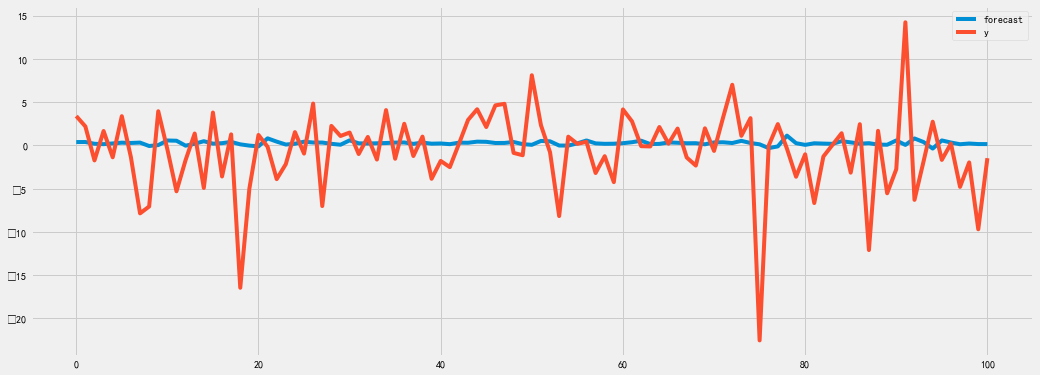

In [45]:
# 用 MA 模型做预测
model = ARMA(google["Close"].diff().iloc[2:].values, order=(0,3))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))
result.plot_predict(start=1000, end=1100)
plt.show()

In [46]:
rmse = math.sqrt(mean_squared_error(google["Close"].diff().iloc[1000:1101].values, result.predict(start=1000,end=1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 4.62282057008924.


In [47]:
"""
ARMA 模型
自回归移动平均模型 (ARMA) 用两个多项式来简要描述（弱）平稳随机过程，一个多项式用于自回归，第二个多项式用于移动平均值。
它是AR和MA模型的融合。"""

'\nARMA 模型\n自回归移动平均模型 (ARMA) 用两个多项式来简要描述（弱）平稳随机过程，一个多项式用于自回归，第二个多项式用于移动平均值。\n它是AR和MA模型的融合。'

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3018
Model:                     ARMA(3, 3)   Log Likelihood              -55408.974
Method:                       css-mle   S.D. of innovations       22751607.645
Date:                Wed, 01 Jun 2022   AIC                         110833.948
Time:                        12:00:19   BIC                         110882.047
Sample:                             0   HQIC                        110851.244
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -2.03e+04   9914.587     -2.047      0.041   -3.97e+04    -864.987
ar.L1.y        0.2053      0.160      1.287      0.198      -0.107       0.518
ar.L2.y        0.7296      0.179      4.078      0.0

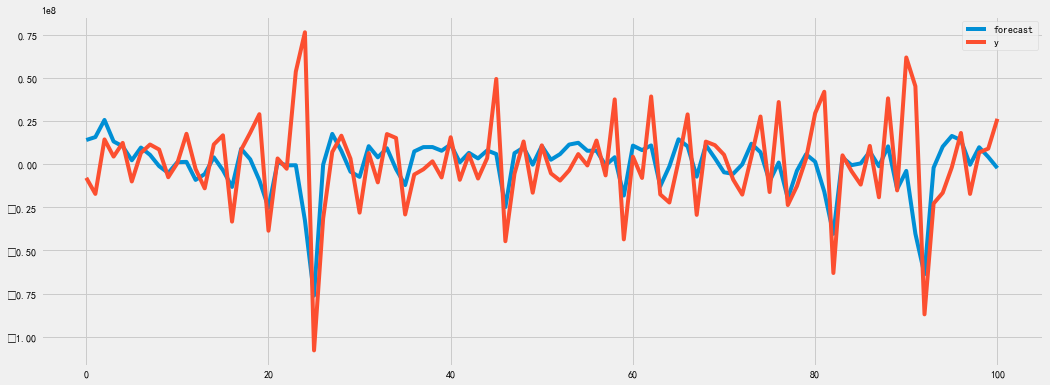

In [48]:
# 使用 ARMA 作预测
# 预测Microsoft库存量
model = ARMA(microsoft["Volume"].diff().iloc[1:].values, order=(3,3))
result = model.fit()
print(result.summary())
print("μ={}, ϕ={}, θ={}".format(result.params[0],result.params[1],result.params[2]))
result.plot_predict(start=1000, end=1100)
plt.show()

In [49]:
rmse = math.sqrt(mean_squared_error(microsoft["Volume"].diff().iloc[1000:1101].values, result.predict(start=1000,end=1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 38038137.51800277.


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3017
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -56385.467
Method:                       css-mle   S.D. of innovations       31647215.008
Date:                Wed, 01 Jun 2022   AIC                         112778.933
Time:                        12:00:24   BIC                         112802.981
Sample:                             1   HQIC                        112787.581
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9984.0302   2.48e+05      0.040      0.968   -4.75e+05    4.95e+05
ar.L1.D.y     -0.8716      0.016    -53.758      0.000      -0.903      -0.840
ar.L2.D.y     -0.4551      0.016    -28.071      0.0

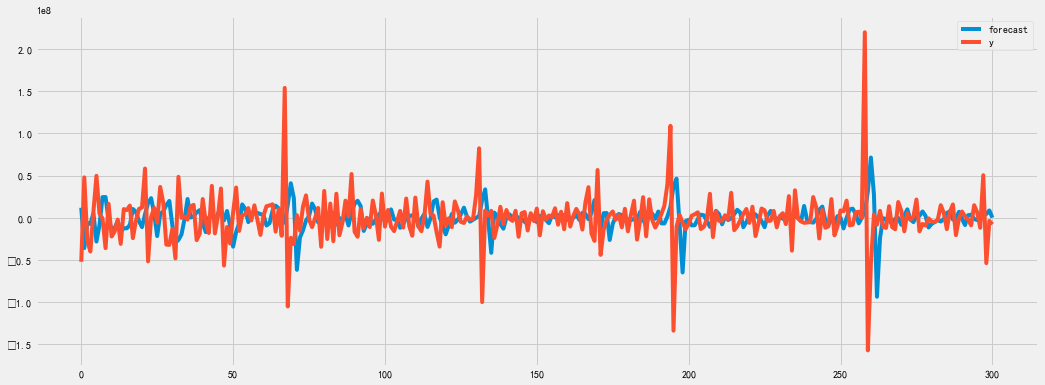

In [50]:
# 使用 ARIMA 做预测
# 预测microsoft股票交易量
rcParams['figure.figsize'] = 16, 6
model = ARIMA(microsoft["Volume"].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()
print(result.summary())
result.plot_predict(start=700, end=1000)
plt.show()

In [51]:
rmse = math.sqrt(mean_squared_error(microsoft["Volume"].diff().iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 61937616.13733011.


In [ ]:
"""
VAR 模型
向量自回归（VAR）是一种随机过程模型，用于捕获多个时间序列之间的线性相互依赖性。
VAR模型通过允许多个evolving variable来概括单变量AR模型。
VAR中的所有变量都以相同的方式进入模型：每个变量都有一个方程式，该方程式根据其自身的滞后值，其他模型变量的滞后值和误差项来解释其演化。
VAR建模不需要像具有联立方程的结构模型那样，需要了解背后有什么“推力”在影响变量：
唯一要求的先验知识是一个假设会在跨时间相互影响的变量列表。
"""
# 预测谷歌和微软的收盘价格
train_sample = pd.concat([google["Close"].diff().iloc[1:],microsoft["Close"].diff().iloc[1:]],axis=1)
model = sm.tsa.VARMAX(train_sample,order=(2,1),trend='c')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=1000)
result.plot_diagnostics()
# 计算误差
rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
print("The root mean squared error is {}.".format(rmse))

D:\software\Anaconda\envs\data_analysis\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.

D:\software\Anaconda\envs\data_analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3018
Model:               SARIMAX(4, 0, 4)   Log Likelihood              -10098.962
Date:                Wed, 01 Jun 2022   AIC                          20217.925
Time:                        12:00:46   BIC                          20278.048
Sample:                             0   HQIC                         20239.544
                               - 3018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1068      0.047      2.258      0.024       0.014       0.200
ar.L1          0.2285      0.006     36.368      0.000       0.216       0.241
ar.L2          1.1234      0.005    212.031      0.0

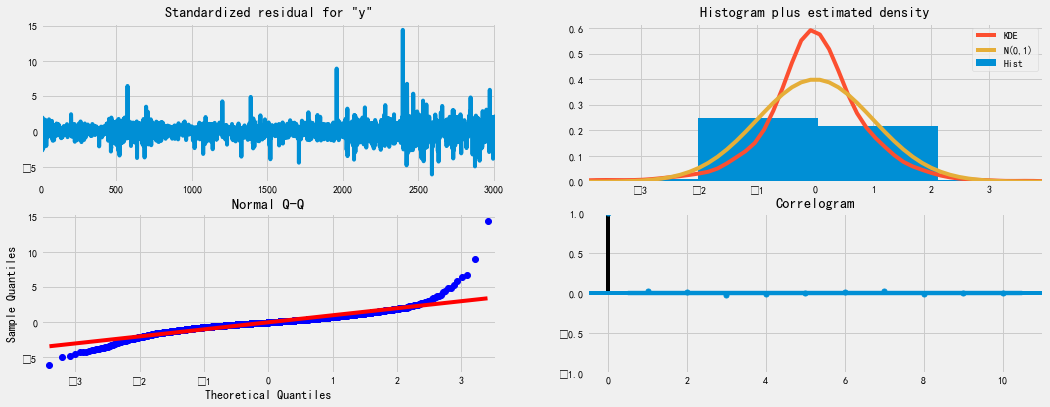

In [52]:
"""
SARIMA models
SARIMA模型对于季节性时间序列的建模非常有用，在季节性时间序列中，给定季节的平均值和其他统计数据在各年中都不是平稳的。
定义的SARIMA模型是非季节自回归综合移动平均（ARMA）和自回归移动平均（ARIMA）模型的直接扩展
"""
# Predicting closing price of Google'
train_sample = google["Close"].diff().iloc[1:].values
model = sm.tsa.SARIMAX(train_sample,order=(4,0,4),trend='c')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

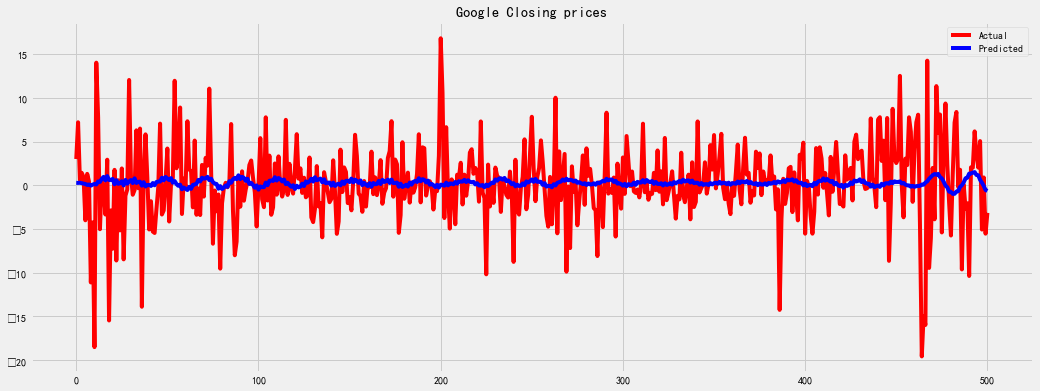

In [53]:
plt.plot(train_sample[1:502],color='red')
plt.plot(predicted_result,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('Google Closing prices')
plt.show()

D:\software\Anaconda\envs\data_analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                   Statespace Model Results                                  
Dep. Variable:                    ['Close', 'Close']   No. Observations:                 3018
Model:             DynamicFactor(factors=1, order=2)   Log Likelihood              -12667.898
Date:                               Wed, 01 Jun 2022   AIC                          25347.796
Time:                                       12:01:44   BIC                          25383.870
Sample:                                            0   HQIC                         25360.768
                                              - 3018                                         
Covariance Type:                                 opg                                         
Ljung-Box (L1) (Q):             2.21, 3.25   Jarque-Bera (JB):   48873.18, 15298.32
Prob(Q):                        0.14, 0.07   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         3.36, 1.82   Skew:                       1.11, 0

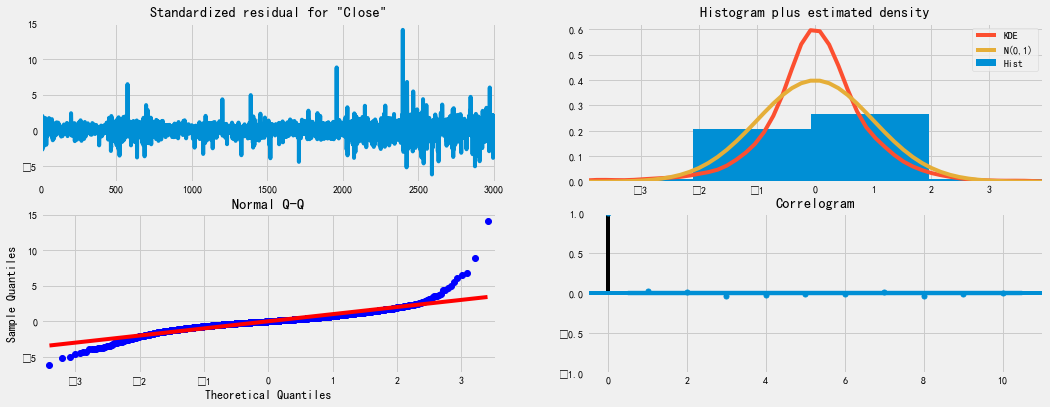

In [54]:
"""
动态因子模型
动态因子模型是用于多元时间序列的灵活模型，其中观察到的内生变量是外生协变量和未观察因子的线性函数，具有向量自回归结构。
未观察到的因素也可能是外部协变量的函数。
因变量方程中的扰动可能是自相关的。
"""
# 预测微软和谷歌的收盘价
train_sample = pd.concat([google["Close"].diff().iloc[1:],microsoft["Close"].diff().iloc[1:]],axis=1)
model = sm.tsa.DynamicFactor(train_sample, k_factors=1, factor_order=2)
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=1000)
result.plot_diagnostics()
# 计算误差
rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
print("The root mean squared error is {}.".format(rmse))